## CS 5330
## Final Project: Garbage Classification
### Group members: Jinghan Gao, Tianhao Zhang, Jialu Bi
This notebook includes codes for preprocessing the data and training the semantic segmentation model.

#### Define transformation

In [1]:
from torchvision import transforms

# Transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

#### Define Dataset and DataLoader

In [2]:
import random
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
from dataset import TacoDataset

random.seed(42)

train_dataset = TacoDataset('./data', transform=transform)

# Define split proportions
train_size = int(0.8 * len(train_dataset))  # 80% for training
valid_size = int(0.1 * len(train_dataset))  # 10% for validation
test_size = len(train_dataset) - train_size - valid_size  # Remaining 10% for testing

# Randomly split the dataset
train_dataset, valid_dataset, test_dataset = random_split(train_dataset, [train_size, valid_size, test_size])

# Create DataLoaders for each split
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=12)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False, num_workers=12)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=12)

#### Load a pre-trained DeepLabV3 model with MobileNetV2 backbone (for faster performance)

In [3]:
import torch.nn as nn
from torchvision import models

model = models.segmentation.deeplabv3_mobilenet_v3_large(pretrained=True)

# Modify the last fully connected layer to match the number of classes we have
num_classes = 60
in_channels = model.classifier[4].in_channels
model.classifier[4] = nn.Conv2d(in_channels, num_classes, kernel_size=(1, 1))

C:\Users\Kevin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Kevin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_MobileNet_V3_Large_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


#### Finetune the model

In [4]:
import torch
import torch.optim as optim
from tqdm import tqdm

# Define hyperparameters
num_epochs = 10
learning_rate = 1e-4
weight_decay = 1e-4

# Choose device
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using CUDA for training.")
elif torch.has_mps:
    device = torch.device("mps")
    print("Using MPS (Apple GPU) for training.")
else:
    device = torch.device("cpu")
    print("CUDA and MPS are not available. Using CPU for training.")

# Move model to the device
model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Helper function for evaluating on the validation set
def evaluate(model, valid_loader, criterion, device):
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():  # No need to compute gradients during validation
        for images, labels in tqdm(valid_loader, desc="Validating", leave=False):
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(images)
            logits = outputs['out']
            
            # Calculate loss
            loss = criterion(logits, labels)
            val_loss += loss.item()

            # Calculate accuracy (assuming classification problem)
            _, predicted = torch.max(logits, 1)

            # Flatten the predicted and labels tensors
            predicted = predicted.view(-1)
            labels = labels.view(-1)

            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    
    val_loss /= len(valid_loader)
    accuracy = correct / total * 100
    
    return val_loss, accuracy

# Training loop
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for images, labels in tqdm(train_loader, total=len(train_loader), desc=f"Epoch {epoch+1}/{num_epochs}"):
        images, labels = images.to(device), labels.to(device)
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(images)
        
        # Calculate loss
        logits = outputs['out']
        loss = criterion(logits, labels)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

        # Calculate accuracy for training data
        _, predicted = torch.max(logits, 1)

        # Flatten the predicted and labels tensors
        predicted = predicted.view(-1)
        labels = labels.view(-1)

        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)
    
    # Calculate average training loss and accuracy for this epoch
    avg_train_loss = running_loss / len(train_loader)
    train_accuracy = correct_train / total_train * 100
    
    # Validation phase
    val_loss, val_accuracy = evaluate(model, valid_loader, criterion, device)
    
    # Print the results for this epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, "
          f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")


Using CUDA for training.


Epoch 1/10: 100%|██████████| 75/75 [01:00<00:00,  1.25it/s]


Epoch [1/10], Train Loss: 2.6559, Train Accuracy: 74.34%, Val Loss: 1.7814, Val Accuracy: 89.79%


Epoch 2/10: 100%|██████████| 75/75 [00:58<00:00,  1.28it/s]


Epoch [2/10], Train Loss: 1.1169, Train Accuracy: 94.25%, Val Loss: 0.7394, Val Accuracy: 95.15%


Epoch 3/10: 100%|██████████| 75/75 [01:00<00:00,  1.23it/s]


Epoch [3/10], Train Loss: 0.5555, Train Accuracy: 95.01%, Val Loss: 0.4193, Val Accuracy: 95.65%


Epoch 4/10: 100%|██████████| 75/75 [00:59<00:00,  1.26it/s]


Epoch [4/10], Train Loss: 0.4019, Train Accuracy: 95.23%, Val Loss: 0.3263, Val Accuracy: 95.80%


Epoch 5/10: 100%|██████████| 75/75 [01:00<00:00,  1.24it/s]


Epoch [5/10], Train Loss: 0.3278, Train Accuracy: 95.38%, Val Loss: 0.2746, Val Accuracy: 95.97%


Epoch 6/10: 100%|██████████| 75/75 [01:00<00:00,  1.25it/s]


Epoch [6/10], Train Loss: 0.2891, Train Accuracy: 95.52%, Val Loss: 0.2483, Val Accuracy: 95.96%


Epoch 7/10: 100%|██████████| 75/75 [00:59<00:00,  1.26it/s]


Epoch [7/10], Train Loss: 0.2581, Train Accuracy: 95.64%, Val Loss: 0.2261, Val Accuracy: 96.10%


Epoch 8/10: 100%|██████████| 75/75 [00:59<00:00,  1.27it/s]


Epoch [8/10], Train Loss: 0.2302, Train Accuracy: 95.95%, Val Loss: 0.2171, Val Accuracy: 96.09%


Epoch 9/10: 100%|██████████| 75/75 [01:01<00:00,  1.21it/s]


Epoch [9/10], Train Loss: 0.2123, Train Accuracy: 96.15%, Val Loss: 0.2060, Val Accuracy: 96.02%


Epoch 10/10: 100%|██████████| 75/75 [01:05<00:00,  1.15it/s]
                                                          

Epoch [10/10], Train Loss: 0.1902, Train Accuracy: 96.45%, Val Loss: 0.1998, Val Accuracy: 96.11%


#### Save the model

In [ ]:
torch.save(model.state_dict(), 'segmentation.pth')

#### Inference

Using CUDA for training.


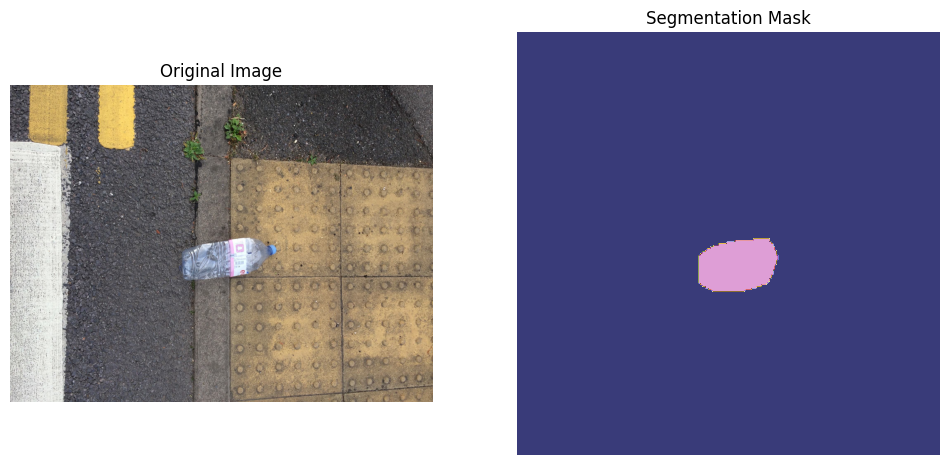

In [8]:
import torch
import torchvision.transforms as T
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Check if CUDA is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using CUDA for training.")
elif torch.has_mps:
    device = torch.device("mps")
    print("Using MPS (Apple GPU) for training.")
else:
    device = torch.device("cpu")
    print("CUDA and MPS are not available. Using CPU for training.")

# Load the pre-trained DeepLabV3 model
model.eval()

# Load an example image (replace with your own image)
image_path = "./data/batch_1/000001.jpg"  # replace with your image path
image = Image.open(image_path)

# Preprocess the image (resize, normalize, and convert to tensor)
transform = T.Compose([
    T.Resize((256, 256)),
    T.ToTensor(),  # Convert image to Tensor and normalize to [0, 1]
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Standard normalization for pre-trained models
])

input_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dimension and move to device

# Run the model
with torch.no_grad():
    output = model(input_tensor)['out'][0]  # Get the segmentation map (without batch dimension)

# Get the segmentation mask (argmax to get the class with highest probability for each pixel)
segmentation_mask = output.argmax(0)  # Shape: (height, width)

# Plot the original image and the segmentation mask
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Show the original image
ax[0].imshow(np.array(image))
ax[0].set_title("Original Image")
ax[0].axis("off")

# Show the segmentation mask
ax[1].imshow(segmentation_mask.cpu().numpy(), cmap="tab20b")
ax[1].set_title("Segmentation Mask")
ax[1].axis("off")

plt.show()


#### Some samples from the dataset, with their annotated mask

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0322802..2.2885156].


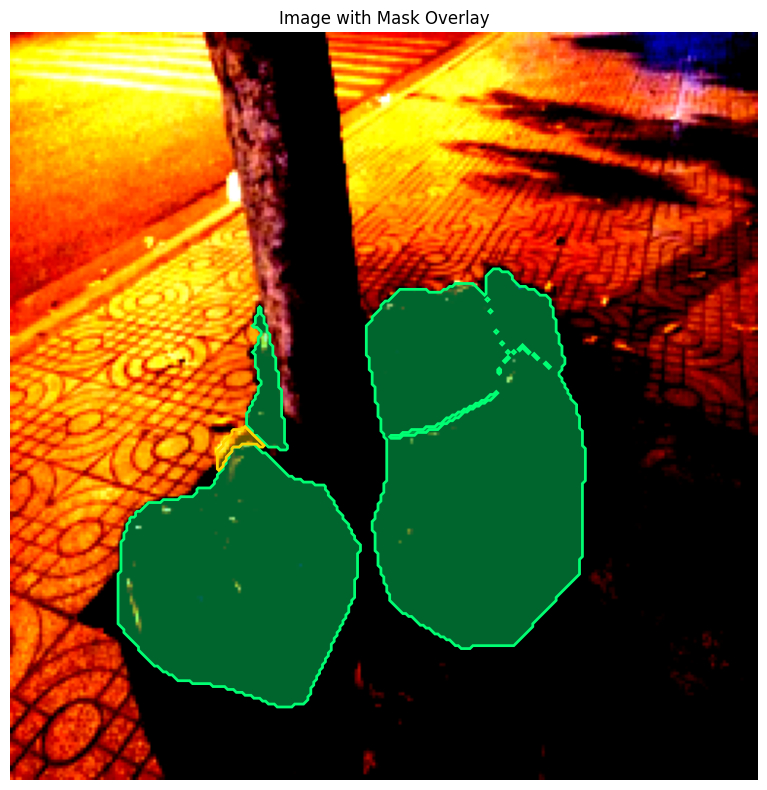

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9980307..2.235994].


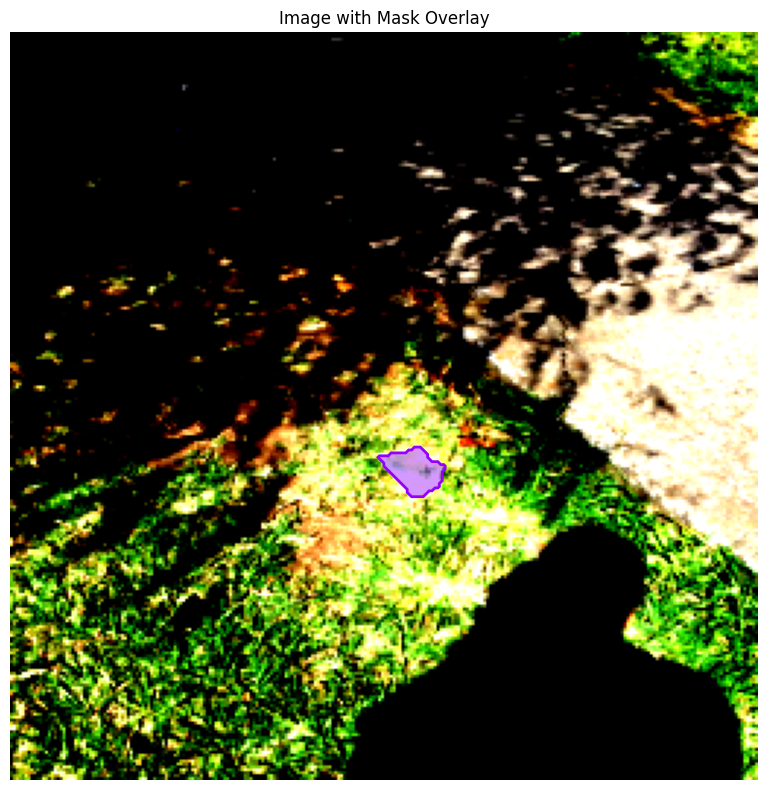

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9980307..2.6051416].


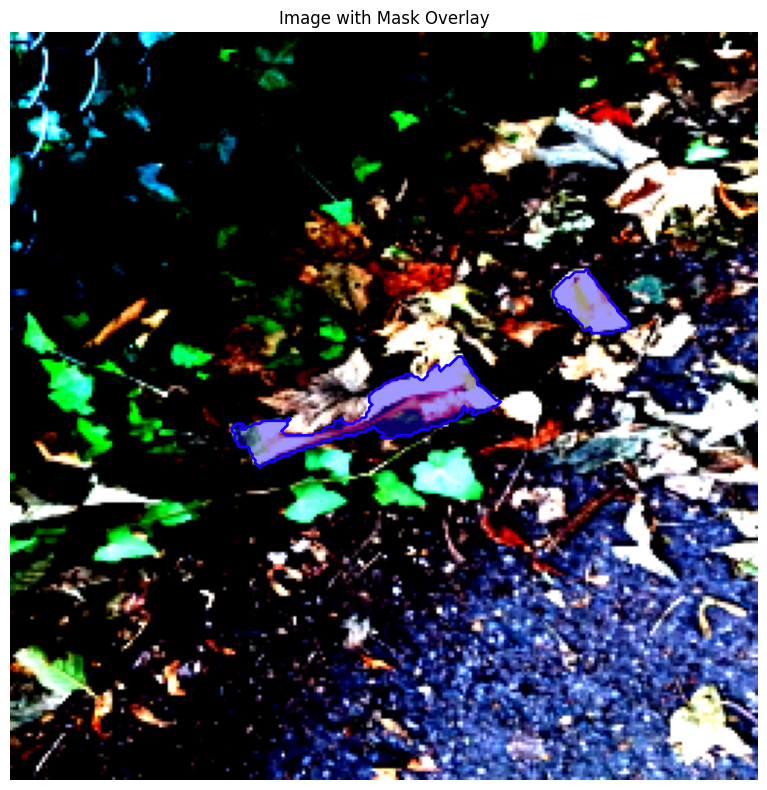

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6505601..2.64].


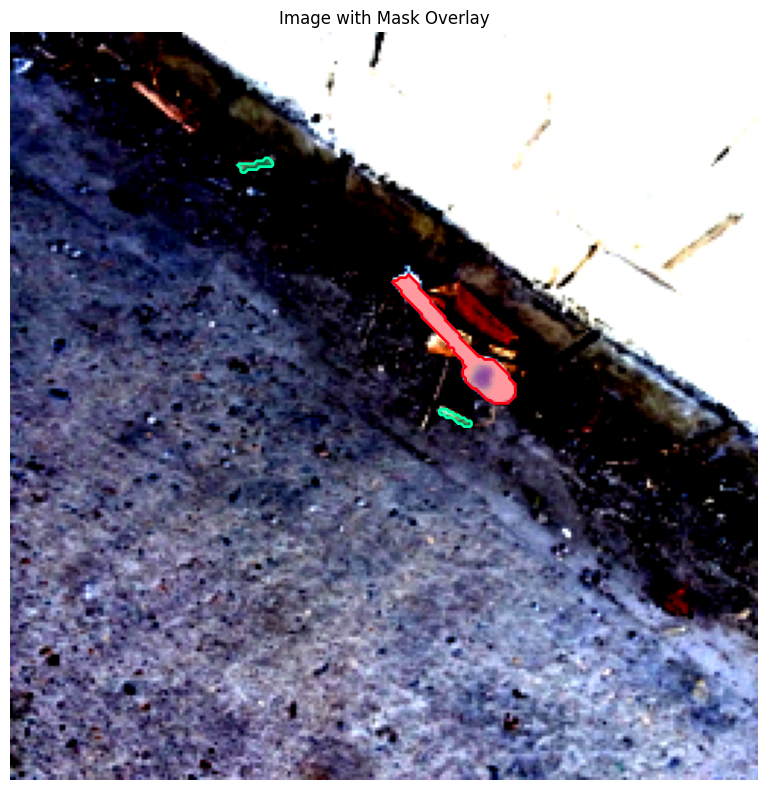

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7906162..2.64].


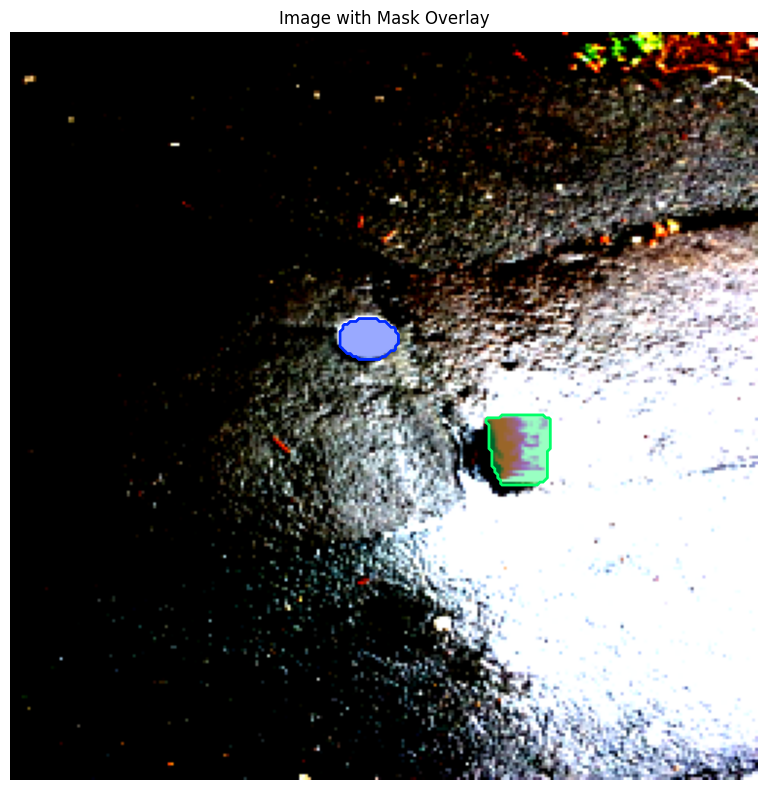

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from matplotlib.patches import Polygon
import colorsys

def visualize_sample_with_mask(dataset, index):
    """
    Visualizes a sample image with its corresponding transparent mask overlay.
    Args:
        dataset: The dataset object.
        index: Index of the sample to visualize.
    """
    # Extract image and mask
    image, mask = dataset[index]

    # Convert image tensor to a NumPy array for visualization
    if isinstance(image, torch.Tensor):
        image = image.permute(1, 2, 0).numpy()  # Convert (C, H, W) to (H, W, C)
    
    # Convert mask tensor to a NumPy array for processing
    if isinstance(mask, torch.Tensor):
        mask = mask.numpy()

    # Create a figure
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    ax.imshow(image)
    ax.axis("off")
    ax.set_title("Image with Mask Overlay")

    # Generate random colors for each unique mask class
    unique_classes = np.unique(mask)
    colors = [colorsys.hsv_to_rgb(np.random.random(), 1, 1) for _ in unique_classes]

    # Overlay each class on the mask
    for class_id, color in zip(unique_classes, colors):
        if class_id == 0:  # Skip the background class (assuming 0 is the background)
            continue
        class_mask = (mask == class_id)
        
        # Find contours for the mask
        contours = find_contours(class_mask)
        for contour in contours:
            poly = Polygon(contour, closed=True, facecolor=color + (0.4,), edgecolor=color, linewidth=2)
            ax.add_patch(poly)

    plt.tight_layout()
    plt.show()


def find_contours(mask):
    """
    Finds contours in a binary mask.
    Args:
        mask: A binary mask where the target region is True.
    Returns:
        contours: A list of contours (each contour is a list of points).
    """
    from skimage import measure
    # Ensure the mask is a NumPy array
    if isinstance(mask, torch.Tensor):
        mask = mask.numpy()
    contours = measure.find_contours(mask.astype(np.float64), level=0.5)
    return [np.flip(contour, axis=1) for contour in contours]


# Example usage: Visualize the first 5 samples with transparent masks
for i in range(5):
    visualize_sample_with_mask(train_dataset, i)